In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # nopep8
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = '1'

FILE_PATH = os.getcwd()
import sys
sys.path.append('\\'.join(FILE_PATH.split('\\')[:3]))
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import preprocess
import pandas as pd
from matplotlib import pyplot as plt
from trainvaltest import trainvaltest

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [2]:
MODEL_NAME = "my_VGG19.h5"
MODEL_PATH = os.path.join(FILE_PATH, MODEL_NAME)
BATCH_SIZE = 16
LABELS, INPUT_SHAPE, Train_Data, Val_Data, Test_Data = trainvaltest(BATCH_SIZE=BATCH_SIZE)
EPOCHS = 20
VERBOSE = 1


Train:
Found 376524 images belonging to 101 classes.
Validation:
Found 37609 images belonging to 101 classes.
Test:
Found 137772 images belonging to 101 classes.

Input shape -> (224, 224, 3)



In [3]:
class CNNBlock(layers.Layer):
    def __init__(self, filters, quad=False, conv_kernel_size=(3, 3), conv_strides=(1, 1), pool_size=(2, 2), pool_strides=(2, 2), padding='same'):
        """block of either double (or triple) conv layers

        Args:
            filters (int): numbers of filters for the conv layers within this block
            quad (bool, optional): whether this conv block contains double (2) or quadruple (4) conv layers. Defaults to False.
            conv_strides (tuple, optional): tuple to set strides value for conv layers. Defaults to (1, 1).
            conv_kernel_size (tuple, optional): kernel size for the conv layers in this block. Defaults to (3, 3).
            pool_size (tuple, optional): pool size for pooling layer for this block. Defaults to (2, 2).
            pool_strides (tuple, optional): strides value for pooling for this block. Defaults to (2, 2).
            padding (str, optional): padding value of conv layers. Defaults to 'same'.
        """
        super(CNNBlock, self).__init__()
        self.quad = quad
        self.pool_size = pool_size
        self.pool_strides = pool_strides
        self.filters = filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_strides = conv_strides
        self.padding = padding

        self.conv1 = self.conv_layer()
        self.conv2 = self.conv_layer()
        if self.quad == True:
            self.conv3 = self.conv_layer()
            self.conv4 = self.conv_layer()
        self.batch_norm = layers.BatchNormalization()
        self.maxpooling = layers.MaxPooling2D(pool_size=self.pool_size, strides=self.pool_strides)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'quad': self.quad,
            'pool_size': self.pool_size,
            'pool_strides': self.pool_strides,
            'filters': self.filters,
            'conv_kernel_size': self.conv_kernel_size,
            'conv_strides': self.conv_strides,
            'padding': self.padding,
        })
        return config

    def conv_layer(self):
        return layers.Conv2D(filters=self.filters, kernel_size=self.conv_kernel_size, strides=self.conv_strides,
                             padding=self.padding, activation=layers.ReLU(), use_bias=False, kernel_initializer='he_normal')

    def __call__(self, input_tensor, training=False):
        """forward propagation

        Args:
            input_tensor (input_tensor): input tensor for this data point
            training (bool): whether to set batch normalization to training or not

        Returns:
            tensor: output of the current CNN block
        """
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        if self.quad == True:
            x = self.conv3(x)
            x = self.conv4(x)
        x = self.batch_norm(x, training=training)
        x = self.maxpooling(x)
        return x

In [4]:
class Model(keras.Model):
    def __init__(self, n_labels):
        """model build via subclassing

        Args:
            n_labels (int): amount of labels for the model to predict
        """
        super(Model, self).__init__()
        self.n_labels = n_labels

        self.preprocess = preprocess.PreprocessingLayers()
        self.cnnblock1 = CNNBlock(filters=64)
        self.cnnblock2 = CNNBlock(filters=128)
        self.cnnblock3 = CNNBlock(filters=256, quad=True)
        self.cnnblock4 = CNNBlock(filters=512, quad=True)
        self.cnnblock5 = CNNBlock(filters=512, quad=True)
        self.globalmaxpooling = layers.GlobalMaxPooling2D()
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(4096, activation=layers.ReLU())
        self.fc2 = layers.Dense(4096, activation=layers.ReLU())
        self.outputs = layers.Dense(self.n_labels)

    @tf.function
    def call(self, input_tensor):
        """forward propagation for the entire model between each layer

        Args:
            input_tensor (tensor): output of the previous layer

        Returns:
            tensor: output of the previous tensor
        """
        x = self.preprocess(input_tensor)
        x = self.cnnblock1(x)
        x = self.cnnblock2(x)
        x = self.cnnblock3(x)
        x = self.cnnblock4(x)
        x = self.cnnblock5(x)
        x = self.globalmaxpooling(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.fc2(x)
        x = self.outputs(x)
        return x

In [5]:
def create_model(inp_shape, n_labels, model_name):
    """creates model (input and output), name layers and compile

    Args:
        inp_shape (tuple(int)): tuple of ints, input shape
        n_labels (int): number of labels for last layer
        model_name (str): name of model
        layer_names (list(str)): list of names for each layer in model

    Returns:
        model: named and configured model with input/output and named layers
    """
    model = keras.Sequential(Model(n_labels=n_labels).layers)    
    model._name = model_name
    model.build(input_shape=(None, *inp_shape))

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])

    model.summary()
    return model

In [6]:
model = create_model(inp_shape=INPUT_SHAPE, n_labels=LABELS, model_name=MODEL_NAME)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=VERBOSE)
callbacks = [earlystopping]

best_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                                  monitor='val_acc',
                                                  save_best_only=True,
                                                  save_freq='epoch',
                                                  verbose=VERBOSE)
callbacks.append(best_checkpoint)

Model: "my_VGG19.h5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layers (Prepro (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1728      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36864     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73728     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     

In [7]:
train = model.fit(Train_Data,
                  epochs=EPOCHS,
                  verbose=VERBOSE,
                  steps_per_epoch=len(Train_Data) // BATCH_SIZE,
                  callbacks=callbacks,
                  validation_data=Val_Data,
                  validation_steps=len(Val_Data) // BATCH_SIZE,
                  use_multiprocessing=True,
                  workers=-1)

Epoch 1/20
1470/1470 [==============================] - 1771s 1s/step - loss: 3.8138 - acc: 0.1295 - val_loss: 3.3294 - val_acc: 0.1862

Epoch 00001: val_acc improved from -inf to 0.18622, saving model to D:\Python\Action Recognition\Custom VGG19\my_VGG19.h5
Epoch 2/20
1470/1470 [==============================] - 1760s 1s/step - loss: 3.0222 - acc: 0.2582 - val_loss: 3.0732 - val_acc: 0.2530

Epoch 00002: val_acc improved from 0.18622 to 0.25300, saving model to D:\Python\Action Recognition\Custom VGG19\my_VGG19.h5
Epoch 3/20
1470/1470 [==============================] - 1728s 1s/step - loss: 2.4681 - acc: 0.3723 - val_loss: 2.3047 - val_acc: 0.4028

Epoch 00003: val_acc improved from 0.25300 to 0.40283, saving model to D:\Python\Action Recognition\Custom VGG19\my_VGG19.h5
Epoch 4/20
1470/1470 [==============================] - 1744s 1s/step - loss: 2.0048 - acc: 0.4789 - val_loss: 2.7080 - val_acc: 0.3643

Epoch 00004: val_acc did not improve from 0.40283
Epoch 5/20
1470/1470 [========

In [8]:
test = model.evaluate(Test_Data, steps=len(Test_Data) // BATCH_SIZE, workers=-1, use_multiprocessing=True, verbose=VERBOSE)

538/538 [==============================] - 580s 1s/step - loss: 5.6294 - acc: 0.1961


In [9]:
train_history = pd.DataFrame(train.history)
train_history.head()

,loss,acc,val_loss,val_acc
0,3.813825,0.129549,3.329401,0.186216
1,3.022164,0.258248,3.073230,0.252997
2,2.468083,0.372321,2.304660,0.402825
3,2.004824,0.478869,2.707997,0.364298
4,1.659898,0.559354,1.461498,0.603168


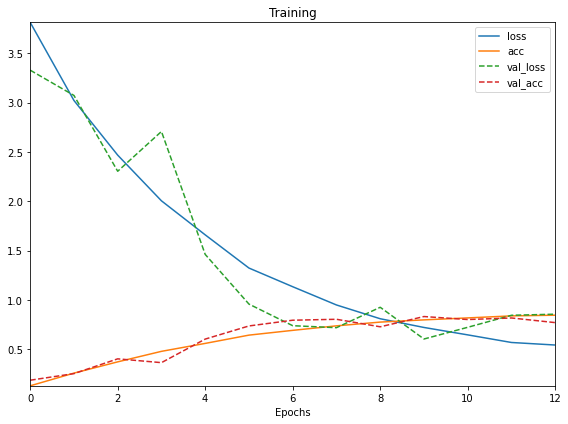

In [12]:
plt.figure(figsize=(8, 6))
plt.title("Training")
def plotline(label):
    return plt.plot(train_history[label], label=label, linestyle='--' if label[:3]=='val' else '-')

for label in train_history.keys():
    plotline(label=label)
plt.xlabel('Epochs')
plt.legend()
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()